<a href="https://colab.research.google.com/github/estefaniabrito/SYS/blob/main/Punto_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Punto 4

Desarrolle un sistema para identificar una palabra clave y autenticar al hablante utilizando herramientas basadas en la Transformada de Fourier. El sistema debe presentarse como un Dashboard en Streamlit y cumplir con las siguientes condiciones: i) Permitir el acceso únicamente si un miembro del grupo pronuncia la palabra clave. ii) Denegar el acceso en cualquier otro caso.
Además, se debe presentar y describir el esquema de solución que incluya: i) Diseño del sistema de detección. ii) La base de datos creada para almacenar los patrones de voz y palabras clave. iii) Las consideraciones técnicas para implementar la solución, incluyendo el uso de la Transformada de Fourier para procesar las señales de voz.

##Algoritmo de solución

¿Cómo diseñamos el sistema de detección?

Mediante el uso de la aplicación "GRABADORA" del celular se grabaron dos audios, uno en el que se menciona la palabra clave: "Señal", y otro en el que se dicen palabras aleatorias distintas a la palabra clave, posterior a esto y como se muestra a continuación ambos audios se agregan a una carpeta comprimida de google drive (**diferente a unal.edu.co**) y de esta manera subirlos a Colab.
Además en la siguiente celda de código también se identifica si el audio que le está entrando al sisema que formato tiene y cuando se tenga identificado, procesarlo en .wav para facilidad de funcionamiento mediante python.

In [ ]:
from google.colab import drive
import os
import zipfile
import subprocess

# Montar Google Drive
drive.mount('/content/drive')

# Definir rutas
zip_path = "/content/drive/MyDrive/PARCIAL 2 SYS.zip"  # Ruta del ZIP
extract_path = "/content/drive/MyDrive/PARCIAL 2 SYS"  # Carpeta destino

# Extraer el ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Extraer en la carpeta especificada

print("Archivos extraídos en:", extract_path)

# Crear carpeta para los archivos WAV
wav_output_path = os.path.join(extract_path, "WAV_files")
os.makedirs(wav_output_path, exist_ok=True)

# Recorrer los archivos de la carpeta extraída
for root, _, files in os.walk(extract_path):
    for file in files:
        # Verificar si el archivo es de audio (MP3, M4A, etc.)
        if file.lower().endswith((".mp3", ".m4a", ".aac", ".ogg")):
            input_file = os.path.join(root, file)
            output_file = os.path.join(wav_output_path, os.path.splitext(file)[0] + ".wav")

            # Convertir a WAV con FFmpeg
            subprocess.call(["ffmpeg", "-y", "-i", input_file, output_file])

            print(f"Convertido: {file} → {output_file}")

print("Conversión completada.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivos extraídos en: /content/drive/MyDrive/PARCIAL 2 SYS
Convertido: PARCIAL 2 SYS.m4a → /content/drive/MyDrive/PARCIAL 2 SYS/WAV_files/PARCIAL 2 SYS.wav
Convertido: PALABRASINCORRECTASSYS.m4a → /content/drive/MyDrive/PARCIAL 2 SYS/WAV_files/PALABRASINCORRECTASSYS.wav
Convertido: PARCIAL2SYS.m4a → /content/drive/MyDrive/PARCIAL 2 SYS/WAV_files/PARCIAL2SYS.wav
Conversión completada.


Se analiza que lo que se ha importado sí sea la carpeta que necesitamos

In [ ]:
import os

# Ruta de la carpeta donde están los archivos WAV
wav_folder = "/content/drive/My Drive/PARCIAL 2 SYS/WAV_files"  # Ajusta si es necesario

# Listar solo archivos .wav
wav_files = [f for f in os.listdir(wav_folder) if f.lower().endswith('.wav')]

# Mostrar lista de archivos encontrados
print("Archivos WAV encontrados:", wav_files)


Archivos WAV encontrados: ['PARCIAL2SYS.wav', 'PARCIAL 2 SYS.wav', 'PALABRASINCORRECTASSYS.wav']


Creamos una carpeta donde guardaremos segmentos de los audios, los cuales tendrán una duración de 1000ms.

In [ ]:
!pip install pydub
from pydub import AudioSegment
import os

# Ruta de los archivos WAV
wav_folder = "/content/drive/My Drive/PARCIAL 2 SYS/WAV_files"
output_folder = "/content/drive/My Drive/PARCIAL 2 SYS/WAV_segments"
os.makedirs(output_folder, exist_ok=True)

# Duración de cada segmento (en milisegundos)
segment_length = 1000  # 5000 ms = 5 segundos

# Recorrer archivos WAV y dividirlos
for file in os.listdir(wav_folder):
    if file.lower().endswith('.wav'):
        file_path = os.path.join(wav_folder, file)
        audio = AudioSegment.from_wav(file_path)

        # Dividir en segmentos
        for i, start in enumerate(range(0, len(audio), segment_length)):
            segment = audio[start:start + segment_length]
            segment_name = f"{os.path.splitext(file)[0]}_part{i}.wav"
            segment.export(os.path.join(output_folder, segment_name), format="wav")

        print(f"Audio {file} dividido en segmentos de {segment_length // 1000} segundos.")

print("Proceso completado.")


Audio PARCIAL2SYS.wav dividido en segmentos de 1 segundos.
Audio PARCIAL 2 SYS.wav dividido en segmentos de 1 segundos.
Audio PALABRASINCORRECTASSYS.wav dividido en segmentos de 1 segundos.
Proceso completado.


**Etiquetamos nuestros segmentos donde se le asigna 1 a los segmentos que tengan la palabra correcta y 0 a los que no la tengan.**

*Tendremos una salida de 12 elementos, y 240 mil muestras por cada segmento (porque $fs*segmentduration=48000*5=240000)$, además nos indicara una salida stereo es decir de dos canales*

Nuestra base de datos vendrá dada por los segmentos de audio extraídos de los archivos .wav, junto con sus respectivas etiquetas.

Cada archivo de audio es segmentado en fragmentos de 5 segundos y almacenado en una estructura de datos donde:

segments contiene los valores de las muestras de audio en formato NumPy.
labels almacena la etiqueta correspondiente a cada segmento (1 si contiene la palabra clave y 0 si no la contiene).

In [ ]:
import os
import numpy as np
import soundfile as sf  # Si no está instalado: !pip install soundfile

# Ruta donde están los archivos extraídos
wav_folder = "/content/drive/My Drive/PARCIAL 2 SYS/WAV_files"

# Listar archivos .wav
wav_files = sorted([f for f in os.listdir(wav_folder) if f.lower().endswith('.wav')])  # Ordenar por nombre
print(f"Archivos encontrados: {wav_files}")

# Parámetros de procesamiento
fs = 48000  # Frecuencia de muestreo
segment_duration = 5  # Duración de cada segmento en segundos
samples_per_segment = int(fs * segment_duration)  # Muestras por segmento

# Inicializar arrays
segments = []
labels = []

# Asignar etiquetas manualmente según el nombre del archivo
keyword_audio = wav_files[0]  # Ajusta si el orden no es correcto
non_keyword_audio = wav_files[1]

# Función para segmentar audio
def segment_audio(file_path, label):
    x, fs = sf.read(file_path)
    num_segments = len(x) // samples_per_segment  # Cantidad de segmentos disponibles

    for i in range(num_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment

        if end > len(x):  # Evitar segmentos incompletos
            continue

        segments.append(x[start:end])  # Guardar segmento
        labels.append(label)  # Asignar etiqueta

        print(f"Segmento {i} de {file_path}: Etiqueta {label}")

# Procesar el audio con la palabra clave (etiqueta 1)
segment_audio(os.path.join(wav_folder, keyword_audio), label=1)

# Procesar el audio sin la palabra clave (etiqueta 0)
segment_audio(os.path.join(wav_folder, non_keyword_audio), label=0)

# Convertir listas a arrays de NumPy
segments = np.array(segments)
labels = np.array(labels)

print(f"Total segmentos: {segments.shape}, Etiquetas: {labels.shape}")


Archivos encontrados: ['PALABRASINCORRECTASSYS.wav', 'PARCIAL 2 SYS.wav', 'PARCIAL2SYS.wav']
Segmento 0 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PALABRASINCORRECTASSYS.wav: Etiqueta 1
Segmento 1 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PALABRASINCORRECTASSYS.wav: Etiqueta 1
Segmento 2 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PALABRASINCORRECTASSYS.wav: Etiqueta 1
Segmento 3 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PALABRASINCORRECTASSYS.wav: Etiqueta 1
Segmento 4 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PALABRASINCORRECTASSYS.wav: Etiqueta 1
Segmento 5 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PALABRASINCORRECTASSYS.wav: Etiqueta 1
Segmento 0 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PARCIAL 2 SYS.wav: Etiqueta 0
Segmento 1 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PARCIAL 2 SYS.wav: Etiqueta 0
Segmento 2 de /content/drive/My Drive/PARCIAL 2 SYS/WAV_files/PARCIAL 2 SYS.wav: Etiqueta 0
Segmento 3 de /content/dr

In [ ]:
from IPython.display import Audio

# Índice del segmento a reproducir
i = 10

# Verificar que el índice no exceda el número de segmentos disponibles
if i < len(segments):
    display(Audio(segments[i].T, rate=fs))
else:
    print(f"El índice {i} está fuera de rango. Máximo: {len(segments)-1}")


Aplicamos la FFT para extraer las frecuencias de los audios

In [ ]:
import numpy as np

# Cálculo del vector de frecuencias
vf = np.fft.rfftfreq(segments.shape[1], 1/fs)  # Frecuencias correspondientes a la FFT

# Aplicar la Transformada Rápida de Fourier y promediar los canales (si son estéreo)
Xw = np.fft.rfft(segments, axis=1).mean(axis=-1)

# Mostrar la forma de los datos transformados
print("Forma de Xw:", Xw.shape)

Forma de Xw: (12, 120001)


Recordemos que la fft devuelve solo la mitad positiva del espectro sin embargo teniendo en cuenta nquist la rfft nos va a devolver la mitad +1 lo cual corresponde al tamaño de Xw

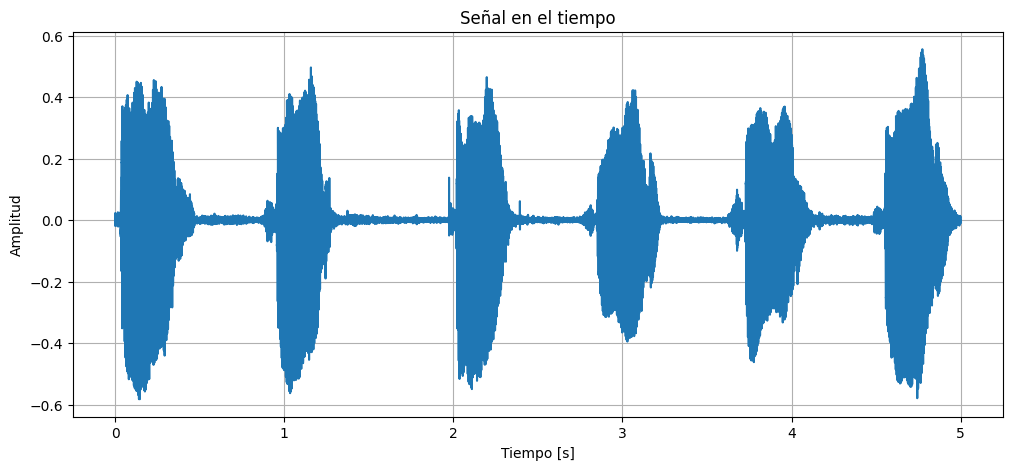

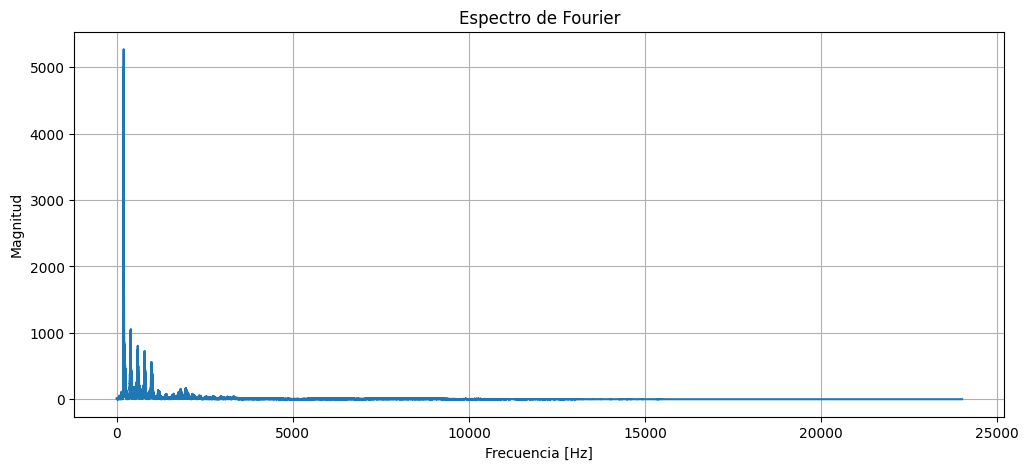

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Índice del segmento a visualizar
i = 10

# Verificar que el índice no exceda el número de segmentos disponibles
if i < len(segments):
    # Crear el vector de tiempo para la señal
    t = np.arange(0, segment_duration, 1/fs)

    # Promediar los dos canales si es estéreo
    x_mean = segments[i].mean(axis=-1)

    # Graficar la señal en el dominio del tiempo
    plt.figure(figsize=(12, 5))
    plt.plot(t, x_mean.T)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.title('Señal en el tiempo')
    plt.grid()
    plt.show()

    # Graficar la FFT en el dominio de la frecuencia
    plt.figure(figsize=(12, 5))
    plt.plot(vf, np.abs(Xw[i]))
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Magnitud')
    plt.title('Espectro de Fourier')
    plt.grid()
    plt.show()

else:
    print(f"El índice {i} está fuera de rango. Máximo: {len(segments)-1}")


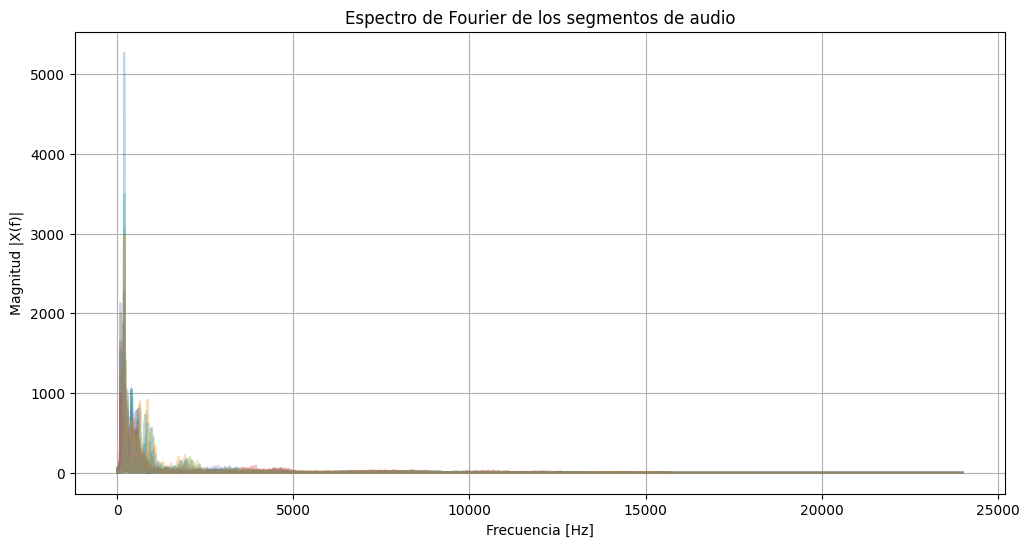

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Graficar el espectro de Fourier para todos los segmentos
plt.figure(figsize=(12, 6))
plt.plot(vf, np.abs(Xw).T, alpha=0.3)  # Transponer para graficar correctamente

plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud |X(f)|')
plt.title('Espectro de Fourier de los segmentos de audio')
plt.grid()
plt.show()


**Procedemos a normalizar los espectros para que  todos sus valores estén entre 0 y 1**

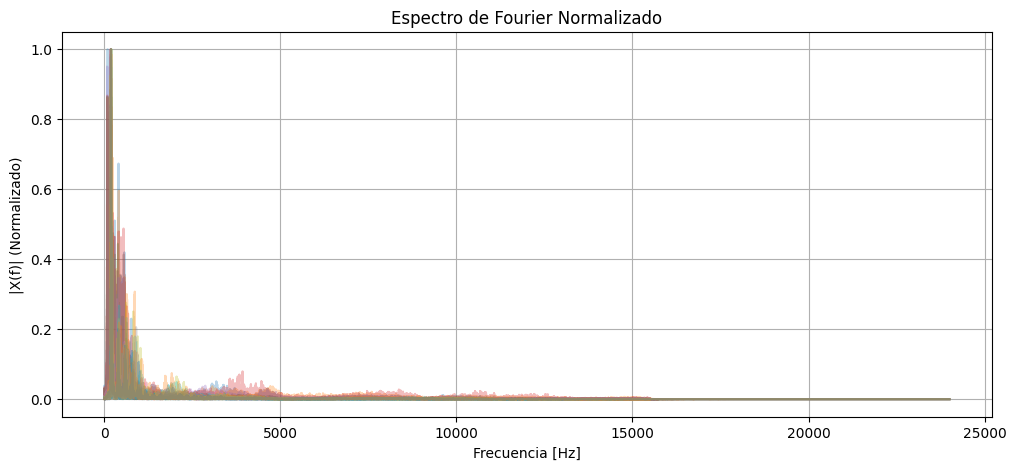

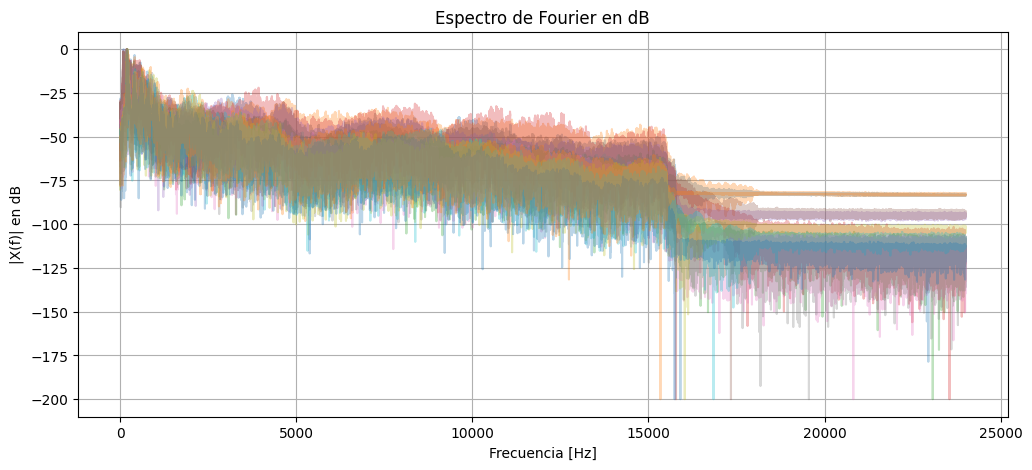

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Normalizar espectros entre 0 y 1
sca = MinMaxScaler()
Xw_ = sca.fit_transform(np.abs(Xw).T).T  # Se normaliza cada espectro

# Graficar espectros normalizados en escala lineal
plt.figure(figsize=(12, 5))
plt.plot(vf, Xw_.T, alpha=0.3)  # Graficar todos los segmentos con transparencia
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|X(f)| (Normalizado)')
plt.title('Espectro de Fourier Normalizado')
plt.grid()
plt.show()

# Graficar espectros en escala dB
plt.figure(figsize=(12, 5))
plt.plot(vf, (20 * np.log10(Xw_ + 1e-10)).T, alpha=0.3)  # Se suma 1e-10 para evitar log(0)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|X(f)| en dB')
plt.title('Espectro de Fourier en dB')
plt.grid()
plt.show()


Vamos a visualizar nuestros espectros en 2D

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Parámetros
fmax = 7000  # Frecuencia máxima a considerar en Hz

# Reducción de dimensionalidad con t-SNE
# Lower the perplexity to be less than the number of samples (12)
red_ = TSNE(perplexity=5, n_components=2, random_state=123, learning_rate='auto', init='pca')

# Aplicar t-SNE solo hasta fmax Hz
X_2D = red_.fit_transform(Xw_[:, :fmax])

# Mostrar forma de los datos transformados
print("Forma de X_2D:", X_2D.shape)


Forma de X_2D: (12, 2)


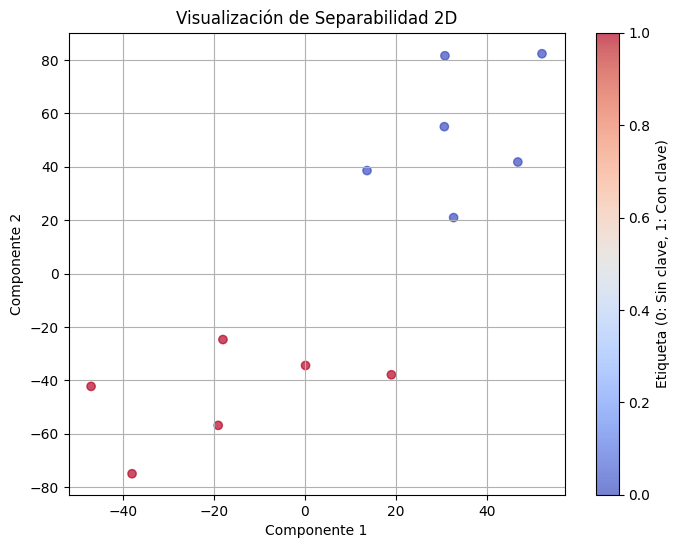

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Graficar la proyección 2D de los datos con t-SNE/PCA
plt.figure(figsize=(8, 6))
# Changed 'label' to 'labels' to use the correct variable for the audio segment labels
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Etiqueta (0: Sin clave, 1: Con clave)")
plt.title("Visualización de Separabilidad 2D")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid()
plt.show()

In [ ]:
from IPython.display import Audio

# Índice del segmento a reproducir
i = 9


# Verificar que el índice no exceda el número de segmentos disponibles
if i < len(segments):
    display(Audio(segments[i].T, rate=fs))
else:
    print(f"El índice {i} está fuera de rango. Máximo: {len(segments)-1}")


In [ ]:
from IPython.display import Audio

# Índice del segmento a reproducir
i = 10

# Verificar que el índice no exceda el número de segmentos disponibles
if i < len(segments):
    display(Audio(segments[i].T, rate=fs))
else:
    print(f"El índice {i} está fuera de rango. Máximo: {len(segments)-1}")

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import os

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(Xw_, labels, test_size=0.2, random_state=42)

# Definir y entrenar el clasificador SVM
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

# Evaluar modelo
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {acc:.4f}")




Precisión del modelo: 1.0000


In [ ]:
import joblib
import os

# Crear carpeta 'modelo' si no existe
os.makedirs('modelo', exist_ok=True)

# Nombre del archivo del modelo
filename_ = 'modelo/deteccion_palabra_clave'

# Guardar solo las variables relevantes (sin name_c)
# Changed 'label' to 'labels' to save the correct variable
model_ = {
    'Xw_': Xw_,  # Espectros normalizados
    'fmax': fmax,  # Frecuencia máxima considerada
    'labels': labels,  # Etiquetas (0 = sin clave, 1 = con clave)
    'vf': vf,  # Vector de frecuencias
    'fs': fs   # Frecuencia de muestreo
}

# Guardar el modelo con joblib
joblib.dump(model_, filename_ + ".pkl")

print(f"Modelo guardado en {filename_}.pkl")

# Removed the redundant code block that was causing the indentation error


Modelo guardado en modelo/deteccion_palabra_clave.pkl


In [ ]:
import joblib

# Definir el nombre del archivo del modelo (¡Corregido!)
filename_ = 'modelo/deteccion_palabra_clave.pkl'  # Usar el nombre del archivo donde guardaste los datos

# Cargar el modelo guardado
my_model_loaded = joblib.load(filename_)

# Mostrar las claves del diccionario cargado
print("Claves del modelo cargado:", my_model_loaded.keys())

Claves del modelo cargado: dict_keys(['Xw_', 'fmax', 'labels', 'vf', 'fs'])


In [ ]:
from google.colab import files
from datetime import datetime
import shutil

# Crear nombre del archivo con fecha y hora actual
namefile = datetime.now().strftime("%Y_%m_%d_%H_%M") + '_modelo'

# Comprimir la carpeta 'modelo' en un archivo ZIP
shutil.make_archive(namefile, 'zip', 'modelo')

# Descargar el archivo ZIP
files.download(namefile + '.zip')

print(f"Archivo {namefile}.zip listo para descargar.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo 2025_02_10_18_15_modelo.zip listo para descargar.
